# Курс «Библиотеки Python для Data Science: продолжение»

## Курсовой проект

### Постановка задачи

__Задача__

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

__Наименование файлов с данными__

course_project_train.csv - обучающий датасет  
course_project_test.csv - тестовый датасет

__Целевая переменная__

Credit Default - факт невыполнения кредитных обязательств

__Метрика качества__

F1-score (sklearn.metrics.f1_score)

__Требования к решению__

_Целевая метрика_

- F1 > 0.5
- Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

_Решение должно содержать_

1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

_Рекомендации для файла с кодом (ipynb)_

- Файл должен содержать заголовки и комментарии (markdown)
- Повторяющиеся операции лучше оформлять в виде функций
- Не делать вывод большого количества строк таблиц (5-10 достаточно)
- По возможности добавлять графики, описывающие данные (около 3-5)
- Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
- Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
- Весь проект должен быть в одном скрипте (файл ipynb).
- Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

#### Описание датасета

- __Home Ownership__ - домовладение
- __Annual Income__ - годовой доход
- __Years in current job__ - количество лет на текущем месте работы
- __Tax Liens__ - налоговые обременения
- __Number of Open Accounts__ - количество открытых счетов
- __Years of Credit History__ - количество лет кредитной истории
- __Maximum Open Credit__ - наибольший открытый кредит
- __Number of Credit Problems__ - количество проблем с кредитом
- __Months since last delinquent__ - количество месяцев с последней просрочки платежа
- __Bankruptcies__ - банкротства
- __Purpose__ - цель кредита
- __Term__ - срок кредита
- __Current Loan Amount__ - текущая сумма кредита
- __Current Credit Balance__ - текущий кредитный баланс
- __Monthly Debt__ - ежемесячный долг
- __Credit Default__ - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

#### Загрузка данных

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [4]:
df_train.shape

(7500, 17)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [7]:
df_test.shape

(2500, 16)

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Приводить типы нет необходимости

### 1. Обзор данных

__Обзор целевой переменной__

In [9]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Есть дипропорция. Значений "1" существенно меньше чем "0"

__Обзор количественных признаков__

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Можно предположить, что по некоторым переменным есть выбросы.

__Обзор номинативных признаков__

In [12]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### 2. Обработка пропусков

In [13]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

__Months since last delinquent__

In [14]:
4081/7500*100

54.413333333333334

Возможно этот показатель лучше не использовать, так как больше половины значений с пропусками.

__Annual Income__

In [15]:
1557/7500*100

20.76

__Credit Score__

In [16]:
1557/7500*100

20.76

__Years in current job__

In [17]:
371/7500*100

4.946666666666666

__Bankruptcies__

In [18]:
14/7500*100

0.18666666666666668

Показатели "Credit Score" и "Annual Income" под вопросом, а для "Years in current job" и "Bankruptcies" пропуски особо на результат не повлияют. Заменим пропуски средним, но будем иметь ввиду количество пропусков для каждого показателя.

In [19]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].mode()[0]
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].mode()[0]
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = df_train['Credit Score'].mode()[0]

In [20]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].mode()[0]
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].mode()[0]
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_test['Months since last delinquent'].mode()[0]
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_test['Credit Score'].mode()[0]

### 3. Обработка выбросов

In [21]:
def emissions(data):
    # Считаем диапазон за границами которого все выброс.    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [22]:
def clear_outlier(data, field):
    # Обрабатываем выброс для конкретного поля.
    r_1, r_2 = emissions(data[field])
    data.loc[(r_1 < data[field]) & (data[field] > r_2), field] = data[field].mode()[0]

In [23]:
def clear_outlier_all(data):
    # Обрабатываем выбросы для всех полей конкретной выборки
    clear_outlier(data, 'Annual Income')
    clear_outlier(data, 'Tax Liens')
    clear_outlier(data, 'Number of Open Accounts')
    clear_outlier(data, 'Years of Credit History')
    clear_outlier(data, 'Maximum Open Credit')
    clear_outlier(data, 'Number of Credit Problems')
    clear_outlier(data, 'Months since last delinquent')
    clear_outlier(data, 'Bankruptcies')
    clear_outlier(data, 'Current Loan Amount')
    clear_outlier(data, 'Current Credit Balance')
    clear_outlier(data, 'Monthly Debt')

In [24]:
clear_outlier_all(df_train)

In [25]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.0,7500.000000,7500.000000,7.500000e+03,7500.0,7500.000000,7500.0,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.119506e+06,0.0,10.719067,17.576560,4.908509e+05,0.0,17.777200,0.0,1.187318e+07,220493.495200,16399.185067,1065.745733,0.281733
std,4.102237e+05,0.0,4.228931,5.940664,3.459979e+05,0.0,9.631749,0.0,3.192612e+07,169023.300456,9748.500526,1437.907935,0.449874
min,1.645970e+05,0.0,2.000000,4.000000,0.000000e+00,0.0,0.000000,0.0,1.124200e+04,0.000000,0.000000,585.000000,0.000000
25%,9.311330e+05,0.0,8.000000,13.500000,2.352680e+05,0.0,14.000000,0.0,1.801690e+05,93646.250000,9243.250000,718.000000,0.000000
50%,9.694750e+05,0.0,10.000000,16.600000,4.211900e+05,0.0,14.000000,0.0,3.095730e+05,184129.000000,15203.500000,738.000000,0.000000
75%,1.334688e+06,0.0,13.000000,21.000000,6.944795e+05,0.0,14.000000,0.0,5.198820e+05,313329.000000,22416.250000,740.000000,1.000000
max,2.351250e+06,0.0,23.000000,34.200000,1.562550e+06,0.0,51.000000,0.0,1.000000e+08,729448.000000,44382.000000,7510.000000,1.000000


In [26]:
clear_outlier_all(df_test)

In [27]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.0,2500.000000,2500.00000,2.500000e+03,2500.0,2500.000000,2500.0,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,1.131898e+06,0.0,10.840400,17.64496,4.960179e+05,0.0,17.563600,0.0,1.215572e+07,225623.373600,17378.355600,1134.273200
std,3.981788e+05,0.0,4.263496,6.14067,3.546929e+05,0.0,6.840224,0.0,3.226097e+07,173711.173699,9469.676384,1563.851754
min,1.065330e+05,0.0,1.000000,3.90000,0.000000e+00,0.0,0.000000,0.0,1.542200e+04,0.000000,93.000000,585.000000
25%,9.365622e+05,0.0,8.000000,13.40000,2.326500e+05,0.0,16.000000,0.0,1.871265e+05,92867.250000,10024.750000,717.000000
50%,1.025145e+06,0.0,10.000000,16.60000,4.250950e+05,0.0,16.000000,0.0,3.223660e+05,188033.500000,16642.500000,738.000000
75%,1.330831e+06,0.0,13.000000,21.40000,6.905965e+05,0.0,16.000000,0.0,5.225825e+05,323460.750000,24146.000000,746.000000
max,2.315340e+06,0.0,23.000000,35.00000,1.588444e+06,0.0,43.000000,0.0,1.000000e+08,747992.000000,44898.000000,7480.000000


### 4. Построение новых признаков

#### Id

In [28]:
df_train['ID'] = df_train.index.tolist()

In [29]:
df_test['ID'] = df_test.index.tolist()

#### Остальные

In [30]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [31]:
for cat_colname in df_test.select_dtypes(include='object').columns[1:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

### 5. Анализ данных

#### Выделение целевой переменной и групп признаков

In [32]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

#### Анализ целевой переменной

__Обзор распределения__

In [33]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Есть некоторая диспропорция

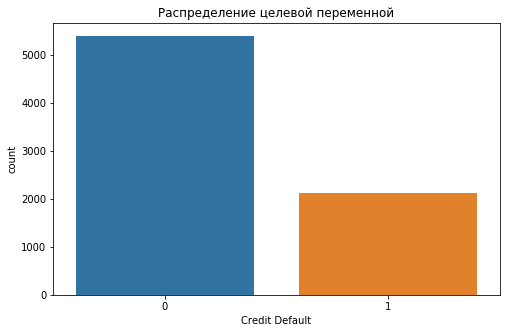

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

__Корреляция с базовыми признаками__

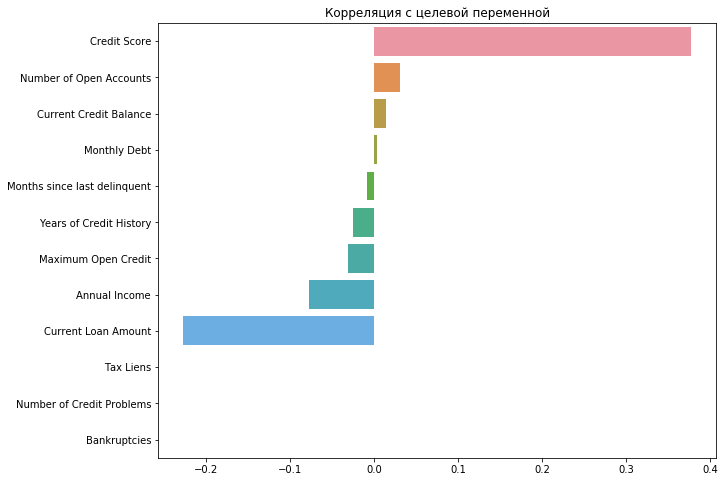

In [37]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

__Оценка признака "Credit Score" в разрезе целевой переменной__

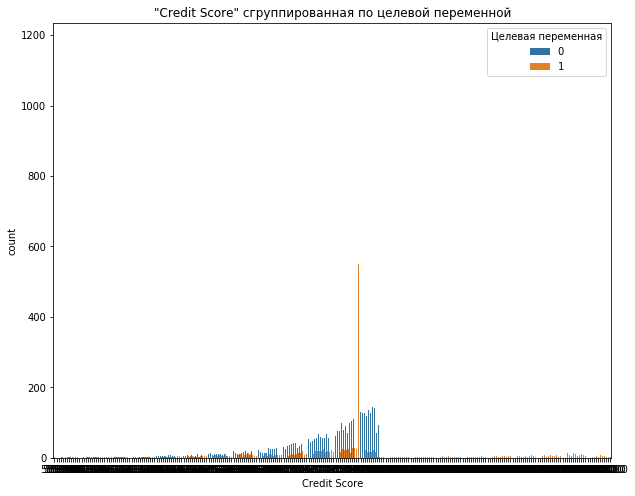

In [39]:
plt.figure(figsize=(10, 8))
sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df_train)
plt.title('"Credit Score" сгруппированная по целевой переменной')
plt.legend(title='Целевая переменная', loc='upper right')
plt.show()